# Notebook on the (non) stability of some problem with matrices

First, Python's boilerplate

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
from IPython.display import display

sns.set(rc={"figure.figsize": (6, 6), "figure.dpi": 160}, style="whitegrid")
np.set_printoptions(precision=3)

We consider complex $3 \times 3$ matrices $M(t) \in \Complex^{3 \times 3 }$ with a real parameter $t \in \Reals$ of the following form, with general term $M(t)_{x,y} = e^{k_{x,y}ti}$

$$
\begin{bmatrix}
    e^{k_{1,1}ti}&e^{k_{1,2}ti}&e^{k_{1,3}ti}\\
    e^{k_{2,1}ti}&e^{k_{2,2}ti}&e^{k_{2,3}ti}\\
    e^{k_{3,1}ti}&e^{k_{3,2}ti}&e^{k_{3,3}ti}\\
\end{bmatrix}
$$

Coefficients $k_{x,y}$ constitue a $3 \times 3$ indexed sequence of real numbers, for instance $(1,2, \dots, 9)$ or $(\sqrt{1}, \sqrt{2}, \dots, \sqrt{19})$  the square roots of the first prime numbers.


In [2]:
# primes nombers
primes = [1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
NDIM = 3


def gen_matrix(t=1, factors=None):
    """For factors [k1, ...k9], computes a matrix M with general term e^(ki * t * j) where 'j' is the imaginary number"""
    # default value
    if factors is None:
        factors = np.sqrt(primes[: NDIM**2])
    return np.exp(np.array(factors, dtype=np.cdouble) * t * 1j).reshape(NDIM, NDIM)



We display for instance the matrix $M(1)$ below.

M as shape (3, 3) with values of type complex128. Content is as follows:


array([[ 0.54 +0.841j,  0.156+0.988j, -0.161+0.987j],
       [-0.617+0.787j, -0.88 +0.476j, -0.985-0.174j],
       [-0.894-0.447j, -0.556-0.831j, -0.346-0.938j]])

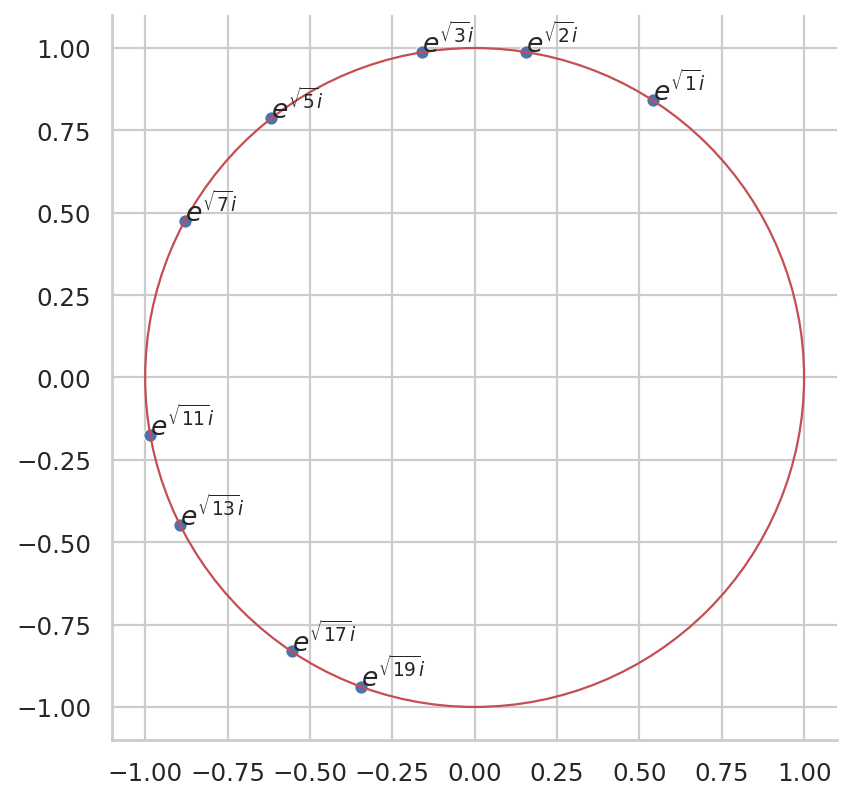

In [3]:
M = gen_matrix(1)
print(f"M as shape {M.shape} with values of type {M.dtype}. Content is as follows:")
display(M)

x_coords, y_coords = np.real(M.flatten()), np.imag(M.flatten())
ax = sns.scatterplot(x=x_coords, y=y_coords)
# ax.figure.set_size_inches(4, 4)
ax.set_aspect("equal", "box")
unit_circle = plt.Circle((0, 0), 1, edgecolor="r", fill=False)
ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
ax.add_patch(unit_circle)
for i in range(M.size):
    ax.annotate(f"$e^{{\sqrt{{{primes[i]}}}i}}$", (x_coords[i], y_coords[i]), rotation=0)
sns.despine()


Now, we extract the 3 eigenvalues and associated eigenvectors from a matrix.
Eigenvalues are sorted in decreasing order of their absolute values (a.k.a. modulus).
Eigenvectors are sorted accordingly.

In [4]:
def extract_eivs(m):
    """Returns complex eigenvalues in decreasing order of module and their eigenvectors"""
    vals, vecs = linalg.eig(m)
    order = np.argsort(-np.absolute(vals))
    
    # NOTE : mind the direction of vectors written as **columns** in vecs
    return np.take_along_axis(vals, order, axis=None), np.take_along_axis(vecs, order.reshape(1,-1), axis=1)


As an example, let's extract eigenvalues $v_i$ and vectors $\lambda_i$ from $M(1)$ and do some sanity checks :
- the eigenvectors are normalized
- eigenvectors $v_i$ are such that $\lambda_i v_i =  M v_i$

In [5]:
vals, vecs = extract_eivs(M)
print(f"Eigenvalues: {vals}")
print(f"Absolute values (sorted): {np.absolute(vals)}")
print(f"Eigenvalues: {vals}")
print(f"Eigenvectors:\n{vecs}")


for n in range(NDIM):
    # chek that the n-th eigenvectors is related to the n-th eigenvalue
    redo = M @ vecs[:, n]
    norm = np.sum(np.absolute(vecs[:, n] * vecs[:, n]))
    assert np.allclose(redo, vals[n]*vecs[:, n])
    assert np.isclose(norm, 1.0)


Eigenvalues: [-0.231+0.684j -0.384-0.367j -0.07 +0.062j]
Absolute values (sorted): [0.722 0.532 0.094]
Eigenvalues: [-0.231+0.684j -0.384-0.367j -0.07 +0.062j]
Eigenvectors:
[[ 0.604+0.j    -0.573-0.231j  0.757+0.j   ]
 [ 0.402+0.382j  0.318-0.31j  -0.582+0.088j]
 [-0.52 +0.238j  0.649+0.j     0.018+0.284j]]


Now, with given $t_1$, $t_n$ and $n$, we generate a sequence of equally spaced points in time $T = (t_1, \dots, t_n)$, we compute all $M(t_i)$ and their associated eigenvalues and vectors.

In [6]:
def get_all_eivs(mini, maxi, nb):
    """Returns a 3*nb array of eigenvalues : 1st row the largest modulus of each matrix, 2nd and 3rd, for nb parameters betwen mini an dmaxi

    ts: the points in time
    vals: the eigenvalues
    vecs: the eigenvectors
    """
    ts = np.linspace(mini, maxi, nb)
    res = [extract_eivs(gen_matrix(t)) for t in ts]
    # unzip
    vals, vecs = zip(*res)
    # vals = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))
    # vecs = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))

    return ts, np.array(vals), np.array(vecs)


For instance, for points in time $t \in (0, 2)$ we got the following datasets

In [7]:
ts, vs, es = get_all_eivs(0, 2, 2)
print(f"A sequence of length 2 of points in time\n{ts}")
print(f"A sequence of length 2 of {NDIM} eigenvalues\n{vs}")
print(f"A sequence of length 2 of {NDIM} eigenvectors, each one of dimension {NDIM}\n{es}")


A sequence of length 2 of points in time
[0. 2.]
A sequence of length 2 of 3 eigenvalues
[[ 3.000e+00+0.j    -9.065e-17+0.j     0.000e+00+0.j   ]
 [-5.051e-01+1.338j  4.263e-02-0.567j -1.667e-01-0.048j]]
A sequence of length 2 of 3 eigenvectors, each one of dimension 3
[[[ 0.577+0.j     0.816+0.j    -0.   -0.j   ]
  [ 0.577-0.j    -0.408-0.j     0.707+0.j   ]
  [ 0.577-0.j    -0.408-0.j    -0.707-0.j   ]]

 [[ 0.271+0.547j -0.363-0.229j  0.736+0.j   ]
  [-0.258-0.371j  0.837+0.j    -0.317+0.593j]
  [ 0.651+0.j    -0.332-0.073j -0.047+0.062j]]]


For instance, we draw the absolute values on the interval $[0, 10]$ with precision $1/100$.

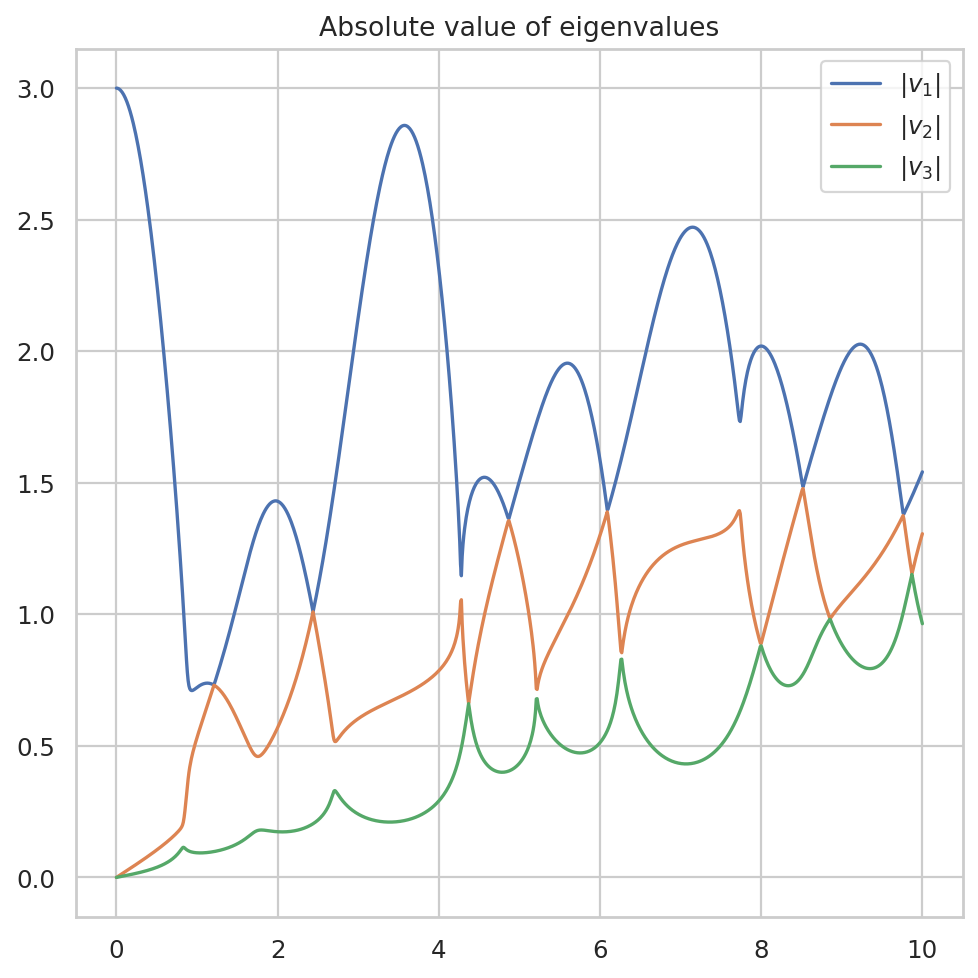

In [8]:
ts, vals, vecs = get_all_eivs(0, 10, 1_001)
fig, ax = plt.subplots(constrained_layout=True)
for k in range(NDIM):
    # print(k, vals[:,k])
    
    # plt.xticks(ticks = np.linspace(MIN, MAX*np.pi/2, X_STEPS), labels = [f"${x}\\times \\frac{{\\pi}}{{2}}$" for x in range(X_STEPS)])
    k_th_vals = vals[:, k]
    sns.lineplot(x=ts, y=np.absolute(k_th_vals), label=f"$|v_{k+1}|$", ax=ax)
    # sns.lineplot(x=ts, y=np.angle(k_th_vals), label="angle", ax=ax)
    # sns.lineplot(x=ts, y=np.real(k_th_vals), label="real", ax=ax)
ax.set_title(f"Absolute value of eigenvalues")
plt.show()


From now on, we generate a larger dataset on the interval $[0, 10.000]$ with precision $1/100$, with 1 million matrixes and eigs.

In [12]:
ts, vals, vecs = get_all_eivs(0, 100, 10_001)

Let $\lambda_1(t)$, $\lambda_2(t)$ and $\lambda_3(t)$ the eigenvalues at point $t$ ordered decreasingly.
Let $v_1(t)$, $v_2(t)$ and $v_3(t)$ their respective eigenvectors.
We are interested into the subset of $I$ of  _interesting points_ such that $\lambda_1(t)$ and $\lambda_2(t)$ are close enough, i.e., $I = \{t \mid |\lambda_1(t)| \approx |\lambda_2(t)| \}$. The relation $r_1 \approx r_2$ is defined by $r_1 \approx r_2 \equiv |r_1-r_2| < k^{-1}$ for some fixed threshold value $k$.


In [37]:
THRESHOLD = 1000
# I_filter = np.abs(np.absolute(vals[:, 0]) - np.absolute(vals[:, 1])) < 1 / THRESHOLD
I_filter = np.isclose(np.absolute(vals[:, 0]), np.absolute(vals[:, 1]), atol = 1 / THRESHOLD, rtol = 0.0)
I_points = ts[I_filter]
I_idx = np.arange(len(ts))[I_filter]
print(f"{len(I_points)} interesting points at times t {I_points}")
print(f"Differences between top eig {np.absolute(vals[I_filter,0]) - np.absolute(vals[I_filter,1])}")
I_idx

10 interesting points at times t [ 1.21  2.44 26.37 38.65 65.21 79.58 81.26 85.08 90.72 96.18]
Differences between top eig [8.371e-04 1.877e-04 6.440e-04 3.916e-04 9.781e-04 7.819e-05 9.975e-04
 3.921e-04 7.909e-05 2.487e-04]


array([ 121,  244, 2637, 3865, 6521, 7958, 8126, 8508, 9072, 9618])

In [ ]:
eivs[0:2, vp1_approx_vp2 == True]
np.absolute(eivs[0, vp1_approx_vp2]) - np.absolute(eivs[1, vp1_approx_vp2])

e1s = vecs[:,0, vp1_approx_vp2 == True]
e2s = vecs[:,1, vp1_approx_vp2 == True]

In [ ]:
t = 0
e1s[:,t]
e2s[:,t]
e1s[:,t] * np.angle(eivs[0,t]) / (e2s[:,t] * np.angle(eivs[1,t]))
# np.angle(0+0j)



In [ ]:
ts_vp1_approx_vp2

In [ ]:
# for ti, vt in enumerate(vp1_approx_vp2):
#     if vt:
#         t = ts[ti]
#         print(ti, t)
#         ratio = (e1s[:,ti] * np.angle(eivs[0,ti])) / (e2s[:,ti] * np.angle(eivs[1,ti]))
ti_vp1_approx_vp2 = [i for i, v in enumerate(vp1_approx_vp2) if v]

ratios = []
for i, ti in enumerate(ti_vp1_approx_vp2):
    ratios.append((e1s[:,i] * np.angle(eivs[0,i])) / (e2s[:,i] * np.angle(eivs[1,i])))
    print(i, ti, ts[ti], np.absolute(ratios[i]))


arr = np.array(ratios)[:,0]
arr

In [ ]:
plot = sns.scatterplot(x = np.real(arr), y=np.imag(arr))
for i,_ in enumerate(ti_vp1_approx_vp2):
    plot.annotate(i, (np.real(arr[i]), np.imag(arr[i])), rotation=0)
